<a href="https://colab.research.google.com/github/catalinamagalvan/PySimMIBCI/blob/main/Example_generate_data_fatigue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data simulation with fatigue effect.
This Google colab notebook illustrates how to generate MI-BCI data with the inclusion of mental fatigue effect from the middle of the session. 
Mental fatigue is associated with increased power in frontal theta (4-8 Hz) and parietal alpha (8-13 Hz) EEG rhythms.

Clone repository

In [ ]:
!git clone https://github.com/catalinamagalvan/PySimMIBCI.git

Cloning into 'PySimMIBCI'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 75 (delta 39), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


Install required packages

In [ ]:
!pip install mne==1.3.0
!pip install fooof==1.0.0
!pip install colorednoise==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 KB 3.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.io import loadmat
import os
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
import sys
sys.path.insert(1, os.path.join('PySimMIBCI', 'utils'))
from datasets import create_BCIIV1_info
from simulation import (set_up_source_forward, generate_when, generate_what,
                        generate_where, add_basal_theta_alpha,
                        add_fatigue_effect)
from noise import add_aperiodic_activity, add_eye_movement

Set parameters of data simulation

In [ ]:
# MI IDs
MI_tasks_IDs = {'MI/left': 1, 'MI/right': 2}
# Sample frequency
sfreq = 1000
# Number of trials
N_trials = 200
# MI trial duration in ms
MI_duration = 4500
# ERD percentage
reduction = 0.5
# Percentage of the session at which fatigue effects start
fatigue_start = 0.5

Here, user g from BCI competition IV dataset 1 was employed as the guide BCI-user. Thus, its aperiodic and aperiodic parameters are employed for the simulation.

In [ ]:
user_params = {'aperiodic_params': [-7.17, 1.14],
               'peak_params': {'G_precentral-lh': [9.54, 1, 2.52],
                               'G_precentral-rh': [10.13, 0.8, 1.62]}}


Generate suitable mne Info object for BCI competition IV dataset 1 data.

In [ ]:
info = create_BCIIV1_info()

#Set up source space and compute forward solution.
Here, fsavarage head model is employed, which is a template brain based on a combination of 40 MRI scans of real brains.

In [ ]:
subject = 'fsaverage'
fwd, source_simulator = set_up_source_forward(subject, info)

Generate when, what and where information for the task-related component in right hand MI vs left hand MI scenario.

In [ ]:
events_info = {0: {'label': 'MI/left', 'duration': MI_duration},
               1: {'label': 'MI/right', 'duration': MI_duration}}
when = generate_when(events_info, N_trials, sfreq)
what = generate_what(MI_tasks_IDs.keys(), when, user_params, MI_duration,
                     sfreq, N_trials, reduction)
where = generate_where(subject)

Add task-related component to source simulator object.

In [ ]:
for label in what.keys():
    for task_ID, task in enumerate(MI_tasks_IDs.keys(), 1):
        when_task = when[np.where(when[:, 2] == task_ID)[0]]
        source_simulator.add_data(label=where[label],
                                  waveform=what[label][task],
                                  events=when_task)

Add fatigue effect

In [ ]:
# Add basal frontal theta and parietal alpha activity
source_simulator = add_basal_theta_alpha(source_simulator, fatigue_start,
                                         subject, subjects_dir)
# Add increased frontal theta and parietal alpha activity
source_simulator = add_fatigue_effect(source_simulator, fatigue_start,
                                      subject,
                                      subjects_dir)

#Project the source time series to sensor space.

(Be patient, running this cell can take around more than an hour).

In [ ]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(ref_channels='average')

<RawArray | 41 x 900000 (900.0 s), ~281.6 MB, data loaded>

Add aperiodic activity (background noise) to raw simulated data. Here, user-specific aperiodic parameters are employed.

In [ ]:
raw_sim = add_aperiodic_activity(raw_sim,
                                 exponent=user_params['aperiodic_params'][1],
                                 offset=user_params['aperiodic_params'][0])

Add eog artifacts by MNE function

In [ ]:
mne.simulation.add_eog(raw_sim)

Add eye-movement artifacts

In [ ]:
add_eye_movement(raw_sim)

Epoch data

In [ ]:
epochs_sim = mne.Epochs(raw_sim, when, MI_tasks_IDs, tmin=0, tmax=4,
                        baseline=None)
epochs_sim_right = epochs_sim['MI/right']
epochs_sim_left = epochs_sim['MI/left']

FOOOF analysis

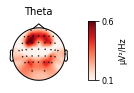

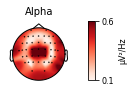

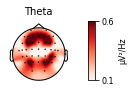

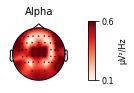

In [ ]:
colormap = None
dB = True
normalize = True
vlim = (0.1, 0.6)
band_theta = [(4, 8, 'Theta')]
band_alpha = [(8, 12, 'Alpha')]
fig = epochs_sim[int(0.5*N_trials):int(0.75*N_trials)].plot_psd_topomap(
    ch_type='eeg', normalize=normalize, bands=band_theta,
    cmap=(colormap, True), dB=dB, vlim=vlim)
fig = epochs_sim[int(0.5*N_trials):int(0.75*N_trials)].plot_psd_topomap(
    ch_type='eeg', normalize=normalize, bands=band_alpha,
    cmap=(colormap, True), dB=dB, vlim=vlim)


fig = epochs_sim[int(0.75*N_trials):].plot_psd_topomap(ch_type='eeg',
                                                       normalize=normalize,
                                                       bands=band_theta,
                                                       cmap=(colormap, True),
                                                       dB=dB, vlim=vlim)
fig = epochs_sim[int(0.75*N_trials):].plot_psd_topomap(ch_type='eeg',
                                                       normalize=normalize,
                                                       bands=band_alpha,
                                                       cmap=(colormap, True),
                                                       dB=dB, vlim=vlim)